In [1]:
%matplotlib inline
import lightkurve as lk
from lightkurve_ext import download_lightcurvefiles
import tic_plot as tplt

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy.io import fits

In [2]:
# 1st Plante Candidate from PHT
tic = 55525572

# Load the light_curves into collection
lcf_coll = download_lightcurvefiles(f"TIC{tic}", mission='TESS', download_dir='./data')
print(len(lcf_coll))


9


In [3]:
# search_res = lk.search.search_lightcurvefile(f"TIC{tic}", mission='TESS')
# search_res.table

Period ~= 83.9000 days
Sectors: [4, 5, 6, 8, 9, 10, 11, 12, 13]


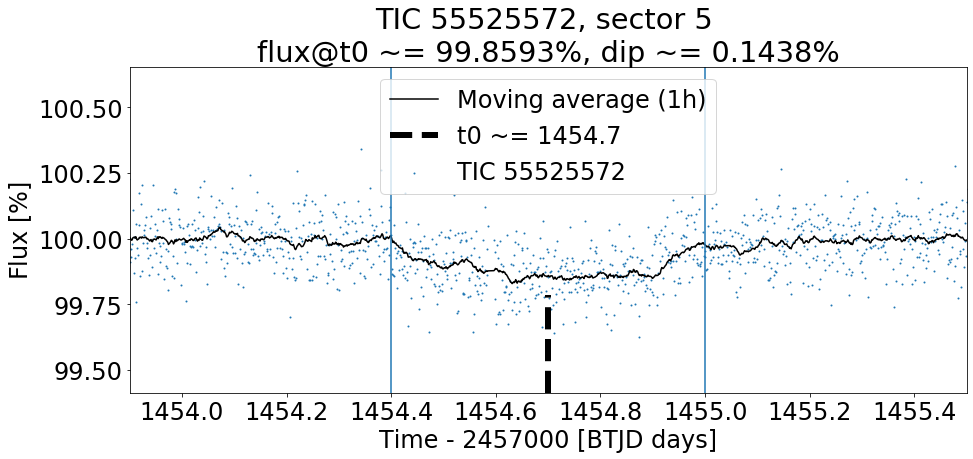

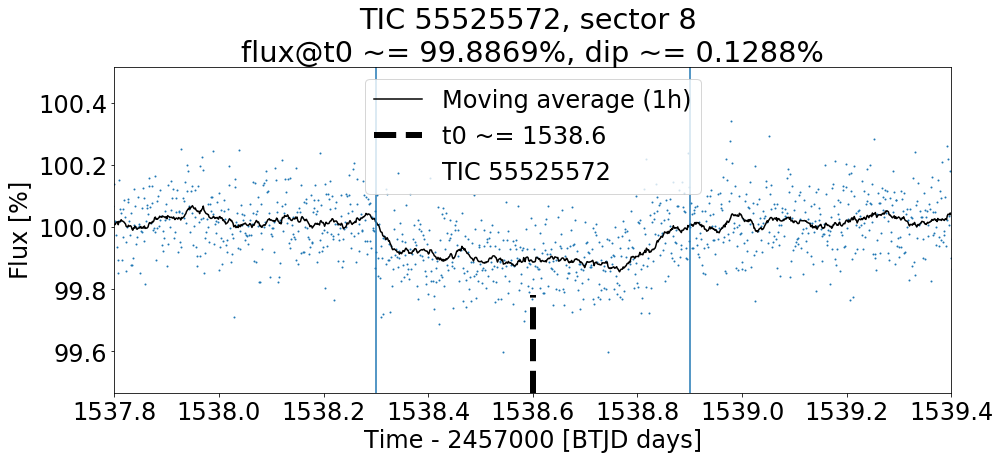

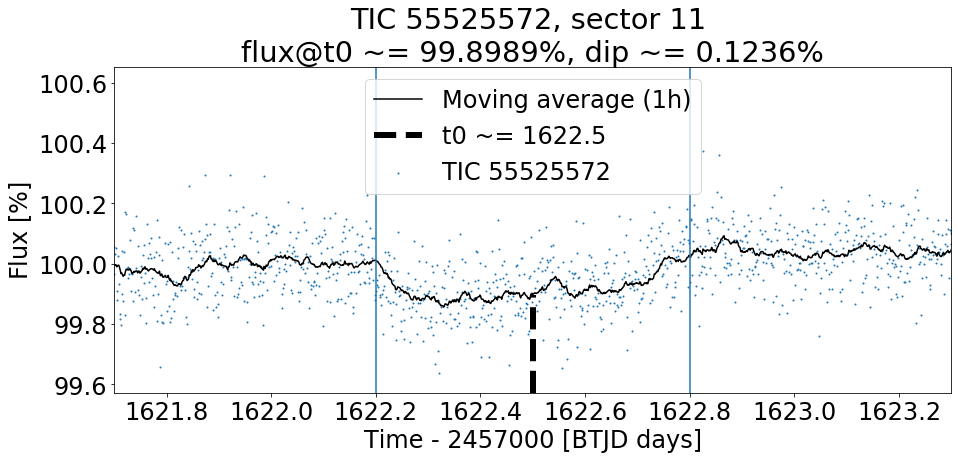

In [7]:
# default plot text properties
def plot_selected(lcf_coll):                      
    matplotlib.rcParams.update({'font.size':24}) 
    matplotlib.rcParams.update({'font.family':'sans-serif'})
    # there should have some data in sector 2, but we don't have it from mast query
    tplt.plot_n_annotate_lcf(tplt.lcf_of_sector(lcf_coll, 5), ax=tplt.lcf_fig().gca()
                        , t0=1454.7, t_start=1454.4, t_end=1455.0)
    tplt.plot_n_annotate_lcf(tplt.lcf_of_sector(lcf_coll, 8), ax=tplt.lcf_fig().gca()
                        , t0=1538.6, t_start=1538.3, t_end=1538.9)
    tplt.plot_n_annotate_lcf(tplt.lcf_of_sector(lcf_coll, 11), ax=tplt.lcf_fig().gca()
                        , t0=1622.5, t_start=1622.2, t_end=1622.8)
    print(f"Period ~= {tplt.as_4decimal(1622.5 - 1538.6)} days")
    return 

# tplt.plot_all(lcf_coll)
plot_selected(lcf_coll)

print("Sectors: " + str(list(map(lambda lcf: lcf.get_header()['SECTOR'], lcf_coll))))


In [ ]:
print(list(map(lambda lc: lc.get_header()['SECTOR'], lcf_coll)))
print(list(map(lambda lc: lc.get_header()['CAMERA'], lcf_coll)))
print(list(map(lambda lc: lc.get_header()['DATE-OBS'], lcf_coll)))


In [ ]:
# combine all the observations together
# or I can just use lcf_coll.stich()
lc = None
for i in range(0, len(lcf_coll)):
    lc_cur = lcf_coll[i].get_lightcurve('PDCSAP_FLUX')
    if lc == None:
        lc = lc_cur    
    else:
        lc.append(lc_cur, inplace=True)
    
print(len(lc.time))

for i in range(0, len(lcf_coll)):
    lc_cur = lcf_coll[i].get_lightcurve('PDCSAP_FLUX')
    print(f"  Sector {lcf_coll[i].get_header()['SECTOR']}: {lc_cur.time.min()} - {lc_cur.time.max()}")

print(lc.time.max()  - lc.time.min())

# use the interactive transit period detection
#   caveat: un-sure if combining observations over time make sense for the algorithm
lc.interact_bls()
